# **Many-to-One GRU**

In [ ]:
!pip install muspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.6 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=e49ce14bf89af1cecd1e52782ee0dc2644a9acfda4374f8358545563bb048198
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import muspy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

Using device: cuda
GPU Name: NVIDIA L4
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Now, that all of the libraries are imported and the devices are prepared, it's time to prepare the data. First, let's load the metadata for our songs.

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0.csv")

Here we define the dataset we are going to use for this model. Upon initialization, it accepts a metadata dataframe and stores all of the files, converted into `muspy.Music` objects. Upon calling `__getitem__`, the song at this particular index is converted to piano-roll format and returns a tuple `(sequence, target)`, where sequence is a random slice of `seq_len` elements from the piano-roll and target is the next element of this sequence.

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, metadata, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.songs = []

        for file in metadata["midi_filename"]:
            file_path = os.path.join("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0/", file)
            muspy_file = muspy.read(file_path)
            self.songs.append(muspy_file)

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        pianoroll_song = self.songs[idx].to_pianoroll_representation()
        pianoroll_song = torch.tensor(pianoroll_song, dtype=torch.float32)

        start_idx = random.randint(0, len(pianoroll_song) - self.seq_len - 1)

        input_seq = pianoroll_song[start_idx:start_idx+self.seq_len]

        target = pianoroll_song[start_idx+self.seq_len]

        return input_seq, target

Due to the I/O on Colab being too slow, it's way faster to load the datasets from a pre-loaded file.

In [ ]:
music_dataset_train = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/train/music_dataset_train_many_to_one_muspy.pt", weights_only=False)
music_dataset_val = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/validation/music_dataset_val_many_to_one_muspy.pt", weights_only=False)

The model we define here is a neural network with 2 GRU layers and a Linear layer to project the output into a size of output_size. It takes a sequence and returns the most likely next tone.

In [ ]:
class ManyToOneGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ManyToOneGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

The Dataloader expects all of the sequences to be of the same length, so we have to define a collate function to pad the shorter ones.

In [ ]:
def collate_fn_packed(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None, None

    sequences, targets = zip(*batch)

    seq_lengths = torch.tensor([s.shape[0] for s in sequences], dtype=torch.long)

    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0.0)

    return sequences_padded, targets_padded, seq_lengths

Now let's define the dataloaders, the model, the optimizer and the criterion:

In [ ]:
music_dataloader_train = DataLoader(music_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
music_dataloader_val = DataLoader(music_dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
many_to_one_gru = ManyToOneGRU(128, 256, 128, 2).to(device)

optimizer = optim.AdamW(many_to_one_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

The training loop computes the MSE between the output, that the model generated and the actual next tone. The model is trained using backpropagation. The train function also keeps track of the loss history for both datasets, so that we can plot them. The model state is saved every 10 epochs.

In [ ]:
def train_many_to_one_gru(net, optimizer, criterion, num_epochs, train_loss_history=[], val_loss_history=[], create_plot=False):
    net.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for sequences, targets in tqdm(music_dataloader_train, f"Epoch {epoch+1}:"):
            sequences = sequences.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            sequences = sequences.reshape(-1, 100, 128)
            targets = targets.reshape(-1, 128)

            outputs = net(sequences)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(music_dataloader_train)
        train_loss_history.append(avg_loss)
        print(f"Average Train Loss: {avg_loss:.4f}")

        net.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for sequences, targets in music_dataloader_val:
                sequences = sequences.to(device)
                targets = targets.to(device)
                outputs = net(sequences)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(music_dataloader_val)
        val_loss_history.append(avg_val_loss)
        print(f"Average Validation Loss: {avg_val_loss:.4f}")
        net.train()


        if (len(train_loss_history) % 10) == 0:
            torch.save(net.state_dict(), f"/content/drive/MyDrive/Piano generation/Project/saved_data/saved_models/many_to_one_gru_fourth_try_epoch_{len(train_loss_history)}.pt")

    if create_plot:
        plt.plot(train_loss_history, label="Training loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Piano generation/Project/saved_data/plots/many_to_one_gru_loss_epoch_{len(train_loss_history)}_plot.png")

    return train_loss_history, val_loss_history

Let's first do 10 epochs and see how the loss behaves:

Epoch 1:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 65.0030


Average Validation Loss: 52.5156


Epoch 2:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 51.9405


Average Validation Loss: 58.5103


Epoch 3:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 49.9695


Average Validation Loss: 41.9029


Epoch 4:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 43.7556


Average Validation Loss: 40.6426


Epoch 5:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 45.0482


Average Validation Loss: 38.1801


Epoch 6:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 44.7933


Average Validation Loss: 44.3380


Epoch 7:: 100%|██████████| 31/31 [00:51<00:00,  1.65s/it]

Average Train Loss: 46.7879


Average Validation Loss: 38.0051


Epoch 8:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 40.0948


Average Validation Loss: 30.4457


Epoch 9:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 37.9240


Average Validation Loss: 32.4705


Epoch 10:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 36.6792


Average Validation Loss: 30.7532


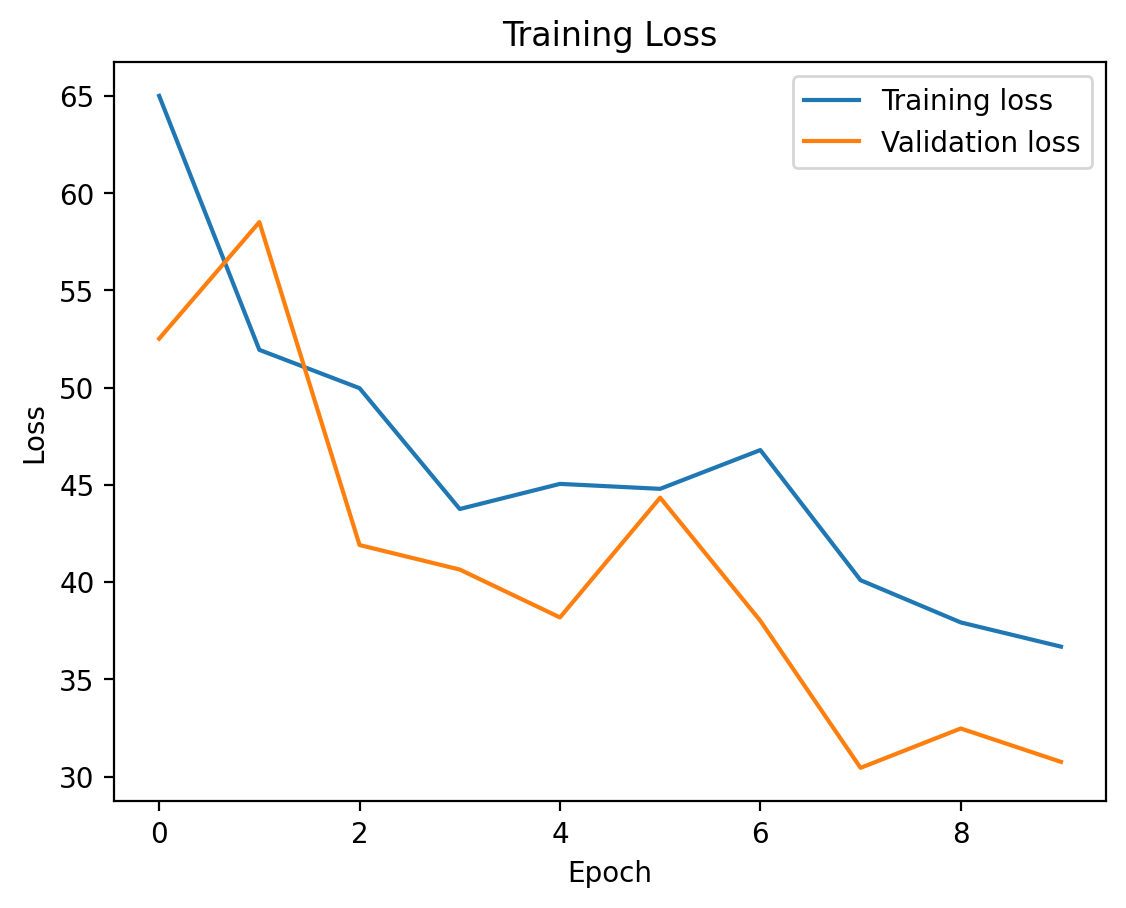

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_gru(many_to_one_gru, optimizer, criterion, 10, [], [], create_plot=True)

In the first 10 epochs, we can see a fast decline in the loss for both the validation and test sets, which indicates, that the model is learning well. Let's do another 30 epochs and see what happens from there:

Epoch 1:: 100%|██████████| 31/31 [00:54<00:00,  1.74s/it]

Average Train Loss: 33.0150


Average Validation Loss: 28.3948


Epoch 2:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


Average Train Loss: 34.7638
Average Validation Loss: 27.7654


Epoch 3:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 33.2847


Average Validation Loss: 25.0674


Epoch 4:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 31.0989


Average Validation Loss: 36.4557


Epoch 5:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 30.0802


Average Validation Loss: 25.7626


Epoch 6:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 26.8649


Average Validation Loss: 24.1277


Epoch 7:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 26.8584


Average Validation Loss: 25.6764


Epoch 8:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 28.2818


Average Validation Loss: 30.3107


Epoch 9:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 28.6491


Average Validation Loss: 27.8814


Epoch 10:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 23.2670


Average Validation Loss: 20.1258


Epoch 11:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 25.0879


Average Validation Loss: 28.5809


Epoch 12:: 100%|██████████| 31/31 [00:51<00:00,  1.67s/it]

Average Train Loss: 21.5987


Average Validation Loss: 33.0675


Epoch 13:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 23.6359


Average Validation Loss: 24.4292


Epoch 14:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 21.1726


Average Validation Loss: 28.1110


Epoch 15:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]


Average Train Loss: 18.7614
Average Validation Loss: 19.6670


Epoch 16:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 21.0097


Average Validation Loss: 20.9841


Epoch 17:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 18.8198


Average Validation Loss: 18.7043


Epoch 18:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 18.5949


Average Validation Loss: 23.9458


Epoch 19:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 20.0138
Average Validation Loss: 16.9521


Epoch 20:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 20.5152


Average Validation Loss: 22.4513


Epoch 21:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 20.8717


Average Validation Loss: 20.9493


Epoch 22:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 16.8466


Average Validation Loss: 24.0256


Epoch 23:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 16.5276


Average Validation Loss: 16.4567


Epoch 24:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 17.8928


Average Validation Loss: 16.5049


Epoch 25:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Train Loss: 18.5122


Average Validation Loss: 20.5985


Epoch 26:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 19.1875


Average Validation Loss: 17.7971


Epoch 27:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 18.2858


Average Validation Loss: 16.9701


Epoch 28:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 18.3254


Average Validation Loss: 20.5218


Epoch 29:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 15.2462


Average Validation Loss: 16.7957


Epoch 30:: 100%|██████████| 31/31 [00:55<00:00,  1.81s/it]

Average Train Loss: 15.8845


Average Validation Loss: 18.9207


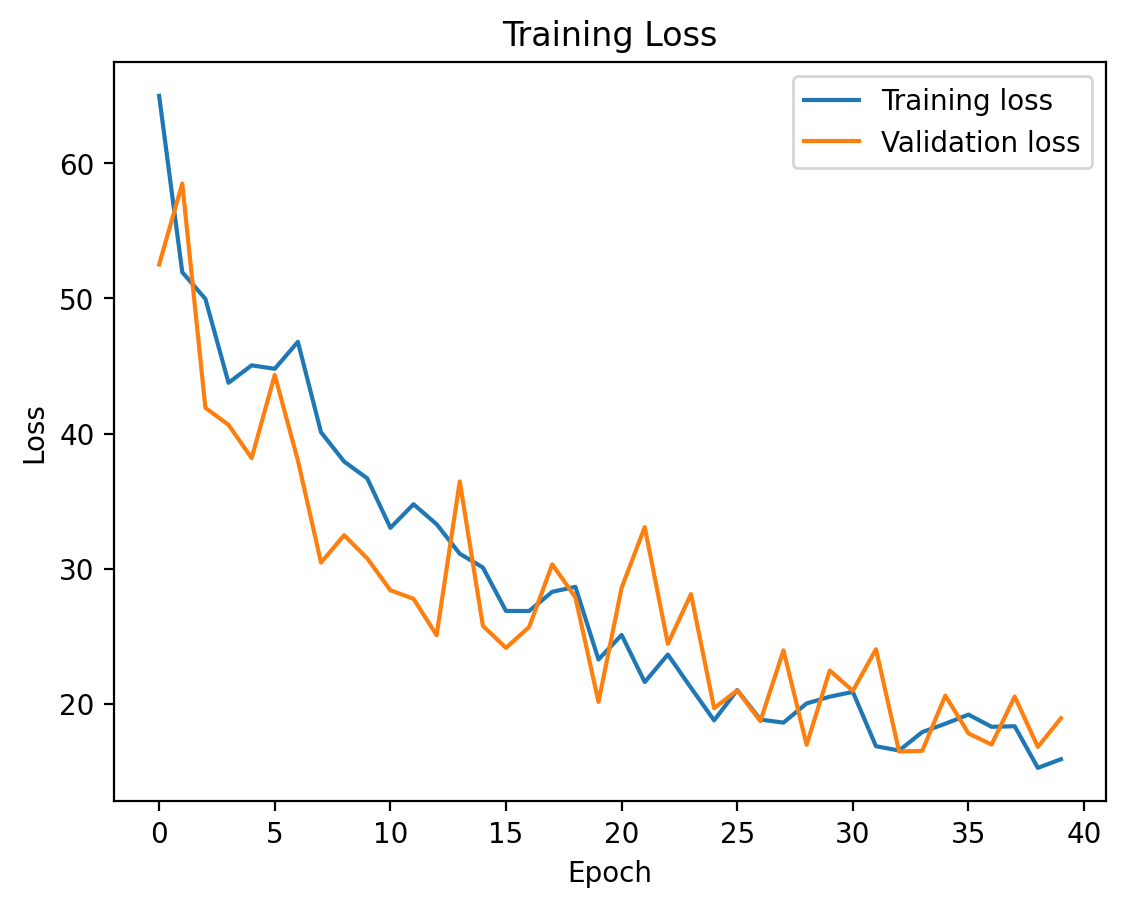

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_gru(many_to_one_gru, optimizer, criterion, 30, train_loss_history, val_loss_history, create_plot=True)

We can see, that it's still going downward. Let's make the epochs 150 and see the plot then:


Epoch 1:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 16.5995


Average Validation Loss: 12.1254


Epoch 2:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 13.9490


Average Validation Loss: 16.1353


Epoch 3:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 15.0384


Average Validation Loss: 17.9099


Epoch 4:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 16.1609


Average Validation Loss: 11.7612


Epoch 5:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 14.2974


Average Validation Loss: 11.2416


Epoch 6:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 15.8961


Average Validation Loss: 12.1206


Epoch 7:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]


Average Train Loss: 13.6637
Average Validation Loss: 11.3946


Epoch 8:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 14.5949


Average Validation Loss: 12.0109


Epoch 9:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 14.6526


Average Validation Loss: 12.5405


Epoch 10:: 100%|██████████| 31/31 [00:54<00:00,  1.74s/it]

Average Train Loss: 13.6470


Average Validation Loss: 16.1245


Epoch 11:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 13.9060


Average Validation Loss: 16.3158


Epoch 12:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 12.5499


Average Validation Loss: 12.7439


Epoch 13:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 11.1841


Average Validation Loss: 13.1071


Epoch 14:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 13.1578


Average Validation Loss: 8.8260


Epoch 15:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 16.3173


Average Validation Loss: 10.6862


Epoch 16:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 12.7963


Average Validation Loss: 20.0558


Epoch 17:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 12.4754


Average Validation Loss: 10.3873


Epoch 18:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]


Average Train Loss: 13.0261
Average Validation Loss: 12.4017


Epoch 19:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 10.8405


Average Validation Loss: 10.4236


Epoch 20:: 100%|██████████| 31/31 [00:55<00:00,  1.77s/it]

Average Train Loss: 12.3816


Average Validation Loss: 12.7985


Epoch 21:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 12.2611


Average Validation Loss: 10.8613


Epoch 22:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 12.6343


Average Validation Loss: 9.3364


Epoch 23:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 11.4590


Average Validation Loss: 10.5732


Epoch 24:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 9.7381


Average Validation Loss: 12.0571


Epoch 25:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]


Average Train Loss: 11.2205
Average Validation Loss: 12.0421


Epoch 26:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 11.3775


Average Validation Loss: 13.0006


Epoch 27:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 10.5750


Average Validation Loss: 10.6538


Epoch 28:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 10.8207


Average Validation Loss: 12.4343


Epoch 29:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 10.8973


Average Validation Loss: 16.8757


Epoch 30:: 100%|██████████| 31/31 [00:55<00:00,  1.77s/it]

Average Train Loss: 10.0695


Average Validation Loss: 10.5088


Epoch 31:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 10.0668


Average Validation Loss: 10.4827


Epoch 32:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 10.5471


Average Validation Loss: 9.8387


Epoch 33:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 10.5366


Average Validation Loss: 10.2232


Epoch 34:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 10.7497


Average Validation Loss: 11.3511


Epoch 35:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 10.5694


Average Validation Loss: 9.7117


Epoch 36:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 9.9109


Average Validation Loss: 8.4217


Epoch 37:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 9.8068


Average Validation Loss: 9.4129


Epoch 38:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 11.3410


Average Validation Loss: 9.8880


Epoch 39:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 10.4914


Average Validation Loss: 5.8540


Epoch 40:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 10.9303


Average Validation Loss: 8.5620


Epoch 41:: 100%|██████████| 31/31 [00:51<00:00,  1.65s/it]

Average Train Loss: 9.9053


Average Validation Loss: 8.2072


Epoch 42:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 9.1322


Average Validation Loss: 7.0345


Epoch 43:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 10.6403
Average Validation Loss: 13.9723


Epoch 44:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 11.4427


Average Validation Loss: 7.4552


Epoch 45:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 8.8502


Average Validation Loss: 12.6644


Epoch 46:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 8.5339


Average Validation Loss: 7.6880


Epoch 47:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 9.2127


Average Validation Loss: 11.5455


Epoch 48:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 10.5802


Average Validation Loss: 8.3582


Epoch 49:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Train Loss: 9.1664


Average Validation Loss: 9.5350


Epoch 50:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.9231


Average Validation Loss: 6.2614


Epoch 51:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 9.3346


Average Validation Loss: 9.4859


Epoch 52:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 9.4350


Average Validation Loss: 9.0812


Epoch 53:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 8.5872


Average Validation Loss: 6.3111


Epoch 54:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 9.6127


Average Validation Loss: 11.1033


Epoch 55:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 8.9398


Average Validation Loss: 10.3002


Epoch 56:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 9.3963


Average Validation Loss: 9.6033


Epoch 57:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.9983


Average Validation Loss: 7.4173


Epoch 58:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 8.6960


Average Validation Loss: 8.2603


Epoch 59:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 7.8159


Average Validation Loss: 11.1159


Epoch 60:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 8.7144


Average Validation Loss: 7.9643


Epoch 61:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 8.7598


Average Validation Loss: 7.0441


Epoch 62:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 8.8076
Average Validation Loss: 6.6909


Epoch 63:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


Average Train Loss: 8.0433
Average Validation Loss: 6.9202


Epoch 64:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 8.7327


Average Validation Loss: 13.1660


Epoch 65:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Train Loss: 9.7454


Average Validation Loss: 7.4960


Epoch 66:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 8.3167


Average Validation Loss: 9.0848


Epoch 67:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 9.0085
Average Validation Loss: 6.3642


Epoch 68:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.9160


Average Validation Loss: 7.9048


Epoch 69:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 10.1065


Average Validation Loss: 10.6491


Epoch 70:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.4421


Average Validation Loss: 9.0351


Epoch 71:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 9.4646


Average Validation Loss: 6.1028


Epoch 72:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 9.0130


Average Validation Loss: 6.0504


Epoch 73:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


Average Train Loss: 8.4887
Average Validation Loss: 8.6435


Epoch 74:: 100%|██████████| 31/31 [00:51<00:00,  1.67s/it]


Average Train Loss: 8.6217
Average Validation Loss: 7.8986


Epoch 75:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 8.3578


Average Validation Loss: 8.3056


Epoch 76:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 9.0427


Average Validation Loss: 6.5978


Epoch 77:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 7.4366


Average Validation Loss: 6.9557


Epoch 78:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 8.6252


Average Validation Loss: 9.1987


Epoch 79:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 7.9118


Average Validation Loss: 6.8618


Epoch 80:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 8.3261


Average Validation Loss: 8.1030


Epoch 81:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 8.2528


Average Validation Loss: 8.3571


Epoch 82:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 8.5812


Average Validation Loss: 9.4119


Epoch 83:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 7.8169


Average Validation Loss: 8.0257


Epoch 84:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 8.9273


Average Validation Loss: 7.8092


Epoch 85:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 6.8974


Average Validation Loss: 5.6657


Epoch 86:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.1909


Average Validation Loss: 9.3812


Epoch 87:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 7.7224


Average Validation Loss: 8.6068


Epoch 88:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.3514


Average Validation Loss: 6.6801


Epoch 89:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 8.6964


Average Validation Loss: 6.4548


Epoch 90:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 8.1833


Average Validation Loss: 4.8963


Epoch 91:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 8.1385


Average Validation Loss: 9.5425


Epoch 92:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 8.6977


Average Validation Loss: 7.1730


Epoch 93:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 8.2478


Average Validation Loss: 5.5237


Epoch 94:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 7.3108


Average Validation Loss: 6.4924


Epoch 95:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 7.6330


Average Validation Loss: 9.0666


Epoch 96:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 7.0348


Average Validation Loss: 11.3526


Epoch 97:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 7.6699


Average Validation Loss: 9.4879


Epoch 98:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 9.5879


Average Validation Loss: 6.2878


Epoch 99:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 7.6666


Average Validation Loss: 12.5873


Epoch 100:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 6.9638


Average Validation Loss: 6.5669


Epoch 101:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 7.1598


Average Validation Loss: 9.5525


Epoch 102:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 7.4805


Average Validation Loss: 8.6612


Epoch 103:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 7.9535


Average Validation Loss: 9.0180


Epoch 104:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 7.9812


Average Validation Loss: 5.9317


Epoch 105:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Train Loss: 8.5015


Average Validation Loss: 6.6925


Epoch 106:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 7.1823


Average Validation Loss: 9.2356


Epoch 107:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 8.0627


Average Validation Loss: 8.5296


Epoch 108:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 9.2527


Average Validation Loss: 6.2657


Epoch 109:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Train Loss: 7.8798


Average Validation Loss: 5.5909


Epoch 110:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 8.0348


Average Validation Loss: 5.8032


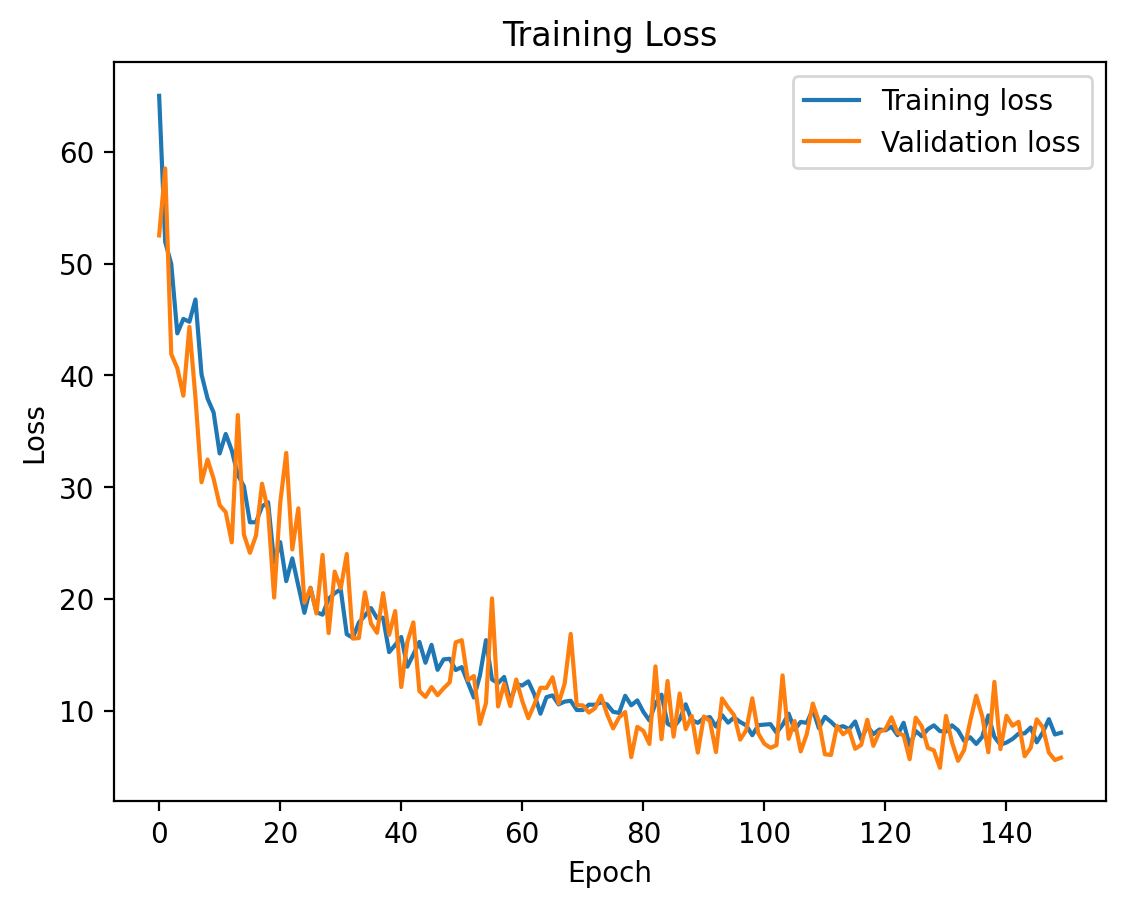

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_one_gru(many_to_one_gru, optimizer, criterion, 110, train_loss_history, val_loss_history, create_plot=True)